In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings

from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
sbn.set(style='white')

In [15]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [16]:
cols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'Price', 'Company ', 'ID', 'Date']

train_data.drop([c for c in train_data.columns if c not in cols], axis=1, inplace=True)
test_data.drop([c for c in test_data.columns if c not in cols], axis=1, inplace=True)

In [17]:
train_abc = train_data.loc[train_data['Company ']=='ABC']
train_def = train_data.loc[train_data['Company ']=='DEF']
train_ghi = train_data.loc[train_data['Company ']=='GHI']

In [18]:
train_abc.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)
train_def.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)
train_ghi.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)

In [19]:
test_abc = test_data.loc[test_data['Company ']=='ABC'].drop(['Company ', 'Date'], axis=1)
test_def = test_data.loc[test_data['Company ']=='DEF'].drop(['Company ', 'Date'], axis=1)
test_ghi = test_data.loc[test_data['Company ']=='GHI'].drop(['Company ', 'Date'], axis=1)

In [20]:
def create_mean_MA(df):
    price = None
    ids = None
    try:
        price = df.pop('Price')
    except:
        x = 1+1 # Just to avoid indentation error in the next line
    try:
        ids = df.pop('ID')
    except:
        x = 1+1
    df['meanMA'] = df.mean(axis=1, skipna=True)
    if price is not None:
        df['Price'] = price
    if ids is not None:
        df['ID'] = ids
    return df

train_abc = create_mean_MA(train_abc)
train_def = create_mean_MA(train_def)
train_ghi = create_mean_MA(train_ghi)
test_abc = create_mean_MA(test_abc)
test_def = create_mean_MA(test_def)
test_ghi = create_mean_MA(test_ghi)

In [21]:
train_abc = train_abc.fillna(0)
train_def = train_def.fillna(0)
train_ghi = train_ghi.fillna(0)

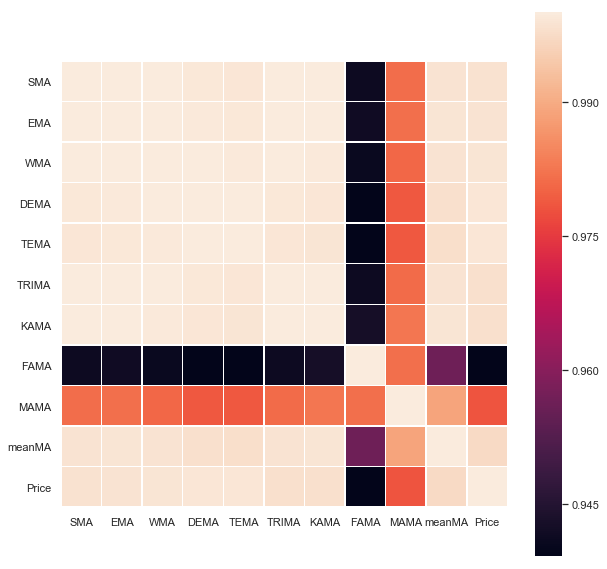

In [22]:
corr = train_abc.corr()
plt.figure(figsize=(10,10))
sbn.heatmap(corr, square=True, linewidth=0.5)

In [23]:
def huber_model(x, y, tune=True):
    if not tune:
        model = HuberRegressor().fit(x,y)
        return model
    model = HuberRegressor()
    param_grid = {
        'epsilon': [1.2, 1.35, 1.5, 1.65],
        'max_iter': [80, 90, 100, 110, 120, 130],
        'alpha': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1],
        'fit_intercept': [True, False],
        'tol': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
    }
    grid = GridSearchCV(estimator=model, cv=3, param_grid=param_grid, n_jobs=-1, verbose=1, error_score='neg_mean_absolute_error')
    grid.fit(x,y)
    return grid


def build_model(df_tr, df_te, algorithm='huber', evaluate=False, tune=False):
    df_train = df_tr.copy()
    df_test = df_te.copy()
    
    y = np.array(df_train.pop('Price'))
    ids = df_test.pop('ID')
    x = df_train.iloc[:,:].values
    x_pred = df_test.iloc[:,:].values
    
    if evaluate:
        x_train = x[:int(len(x)*0.9)]
        x_test = x[int(len(x)*0.9):]
        y_train = y[:int(len(y)*0.9)]
        y_test = y[int(len(y)*0.9):]
        model = None
        if algorithm is 'huber':
            model = huber_model(x_train, y_train, tune=tune)
        y_pred = model.predict(x_test)
        error = mean_absolute_error(y_test, y_pred)
        return error
    model = None
    if algorithm is 'huber':
        model = huber_model(x, y)
    y_pred = model.predict(x_pred)
    df_pred = pd.DataFrame({'ID': ids, 'Price': list(y_pred)})
    return df_pred

In [24]:
error_abc = build_model(train_abc, test_abc, evaluate=True, tune=False)
error_def = build_model(train_def, test_def, evaluate=True, tune=False)
error_ghi = build_model(train_ghi, test_ghi, evaluate=True, tune=False)

print((error_abc+error_def+error_ghi)/3)

5.073241203377339


In [25]:
pred_abc = build_model(train_abc, test_abc, evaluate=False)
pred_def = build_model(train_def, test_def, evaluate=False)
pred_ghi = build_model(train_ghi, test_ghi, evaluate=False)

pred = pd.concat([pred_abc, pred_def, pred_ghi])
pred.sort_values(by='ID', inplace=True)
pred.to_csv('all_MA_3_Huber_Regression.csv', index=False)

Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  1.5min finished


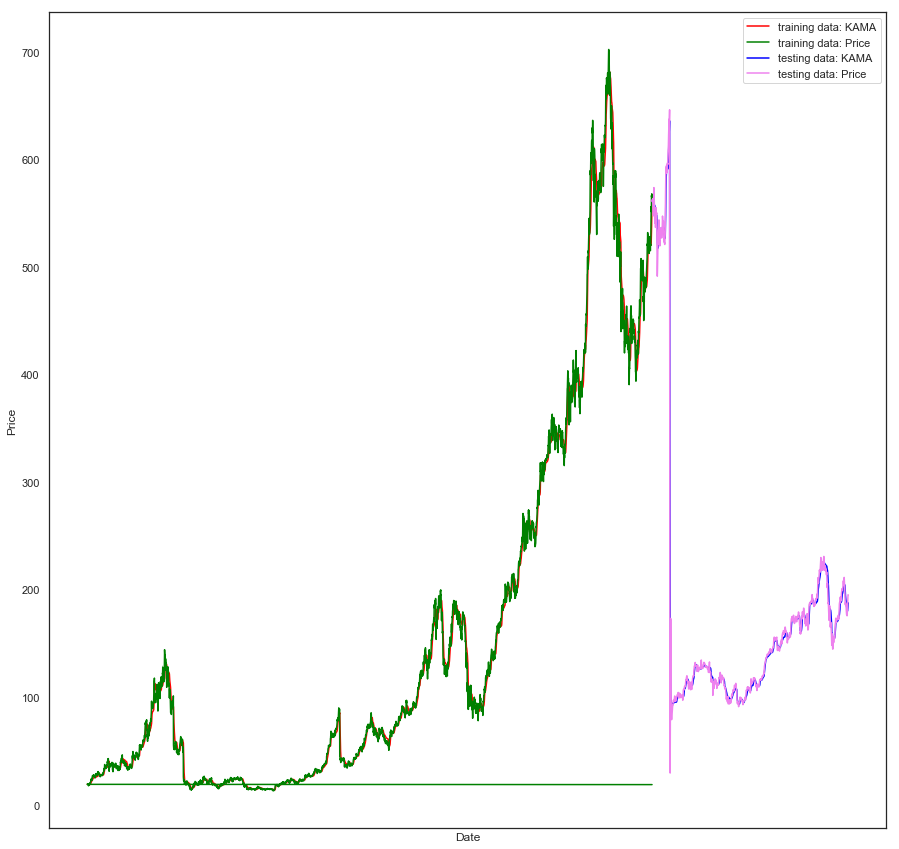

In [26]:
test_data['Price'] = pred['Price']

plt.figure(figsize=(15,15))
sbn.lineplot(x='Date', y='KAMA', data=train_data.loc[train_data['Company ']=='ABC'], label='training data: KAMA', color='red', sort=False)
sbn.lineplot(x='Date', y='Price', data=train_data.loc[train_data['Company ']=='ABC'], label='training data: Price', color='green', sort=False)
sbn.lineplot(x='Date', y='KAMA', data=test_data.loc[test_data['Company ']=='ABC'], label='testing data: KAMA', color='blue', sort=False)
sbn.lineplot(x='Date', y='Price', data=test_data.loc[test_data['Company ']=='ABC'], label='testing data: Price', color='violet', sort=False)
plt.legend()
plt.xticks([],[])
plt.show()